### Test $k_p$ branch

Print out emulator calls and find a log like for a given point in compressed parameter space. I'm running this notebook with the latest kp_change branch and with commit `fe6459468c6370db24e6ab4e2ce2f6a4ccb99e80` (which was shortly before changes to the `recons_cosmo` branch). As far as I understand it these two versions of the code should return the same set of emulator calls for a given point in likelihood space when not changing $g_\star$ or $f_\star$, but this is currently not what I find.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our modules
import likelihood
import data_MPGADGET
import gp_emulator
import p1d_arxiv
import time

In [2]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
# specify simulation to use to generate synthetic data
test_sim_num=15
data=data_MPGADGET.P1D_MPGADGET(sim_number=test_sim_num,
                                basedir=basedir,
                                skewers_label=skewers_label,
                                data_cov_factor=1)

In [3]:
# specify redshift range
z_max=4
# do not use test_sim_num that was used in generating mock data
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=test_sim_num,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [4]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=True,paramList=paramList,train=False,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc)
emu.load_default()

Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Rescaled params to unity volume
Emulator hyperparameters loaded


 /home/chris/.local/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


In [5]:
# Likelihood parameters
like_params=["Delta2_star","n_star","ln_tau_0","ln_tau_1","ln_sigT_kms_0","ln_sigT_kms_1",
             "ln_gamma_0","ln_gamma_1","ln_kF_0","ln_kF_1"]
like_param_limits=[[0.24, 0.47], [-2.352, -2.25], [-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2], 
                   [-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2]]

In [6]:
like=likelihood.Likelihood(data=data,emulator=emu,
                            free_parameters=like_params,
                            free_param_limits=like_param_limits,
                            verbose=False,
                            prior_Gauss_rms=-1,
                            emu_cov_factor=1)

In [12]:
print("Just verifying that the parameter limits are the same inside the code so that the same Delta2_ps should be coming out")
print("Min delta_star",like.free_params[0].min_value)
print("Max delta_star",like.free_params[0].max_value)

Just verifying that the parameter limits are the same inside the code so that the same Delta2_ps should be coming out
Min delta_star 0.24
Max delta_star 0.47


## Compare emulator calls

In [8]:
## Evaluate log_prob at random point in parameter space
#theta=np.random.uniform(0,1,len(like.free_params))
theta=np.ones(len(like_params))*0.5 ## Just pick the middle of likelihood space
tic=time.perf_counter()
like_test=like.log_prob(theta)
toc=time.perf_counter()
print("Took ", toc-tic, "s to evaluate a likelihood")

Took  0.2822029550006846 s to evaluate a likelihood


In [9]:
like_test

-19.26969957143996

In [10]:
like.theory.get_emulator_calls(like.parameters_from_sampling_point(theta))

[{'Delta2_p': 0.6270563235900218,
  'n_p': -2.30461333663729,
  'alpha_p': -0.21533679682862006,
  'mF': 0.8507256483811173,
  'gamma': 1.5534927645653829,
  'sigT_Mpc': 0.1307860745402682,
  'kF_Mpc': 9.23464482319423},
 {'Delta2_p': 0.5374877752714284,
  'n_p': -2.304604511109575,
  'alpha_p': -0.21534221605998777,
  'mF': 0.8145423945568311,
  'gamma': 1.5449855838581277,
  'sigT_Mpc': 0.13051259871602378,
  'kF_Mpc': 9.574547467246399},
 {'Delta2_p': 0.4655076684435753,
  'n_p': -2.3045956356722477,
  'alpha_p': -0.21534771878114808,
  'mF': 0.7709160253724354,
  'gamma': 1.535466821877,
  'sigT_Mpc': 0.12986717236418982,
  'kF_Mpc': 9.913782321346165},
 {'Delta2_p': 0.4068805468706847,
  'n_p': -2.304587115575006,
  'alpha_p': -0.21535362221611123,
  'mF': 0.7191184346490203,
  'gamma': 1.5246254858011445,
  'sigT_Mpc': 0.1290634359857027,
  'kF_Mpc': 10.258137262415408},
 {'Delta2_p': 0.35854684085082295,
  'n_p': -2.3045787012978227,
  'alpha_p': -0.21535925155389007,
  'mF': 0.

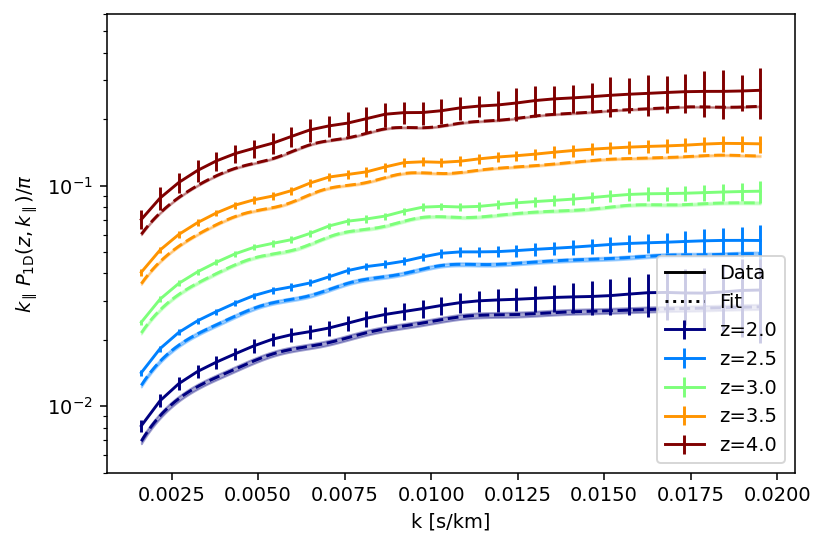

In [11]:
## Plot p1d to make sure emulator calls look reasonable by eye
## the emulator bug I found would result in huge uncertanties
## on the predicted p1d
like.plot_p1d(plot_every_iz=2)